# scrambling mechanism

In [141]:
from qiskit import QuantumCircuit
from qiskit.circuit.random import random_circuit
from qiskit_aer import Aer
from qiskit.compiler import transpile
from qiskit.quantum_info import Statevector, DensityMatrix, random_statevector, partial_trace

from scipy.linalg import sqrtm
import pandas as pd

import numpy as np
import secrets, time, uuid, hashlib

In [142]:
# generate randomized statevectors for testing 
num_wavefunctions = 32
num_qubits = 4 
wave_functions = []

i = 0 
while i < num_wavefunctions: 
    wave_functions.append(random_statevector(dims = 2))
    i += 1

# grouping num_qubits qubits together 
quotient = num_wavefunctions // num_qubits

groups = []

i = 0
while i < num_wavefunctions: 
    groups.append([wave_functions[i:i+num_qubits]])
    i += num_qubits


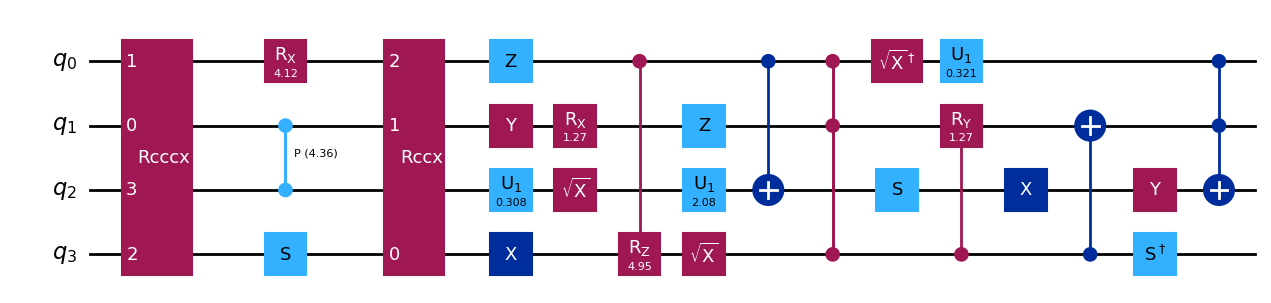

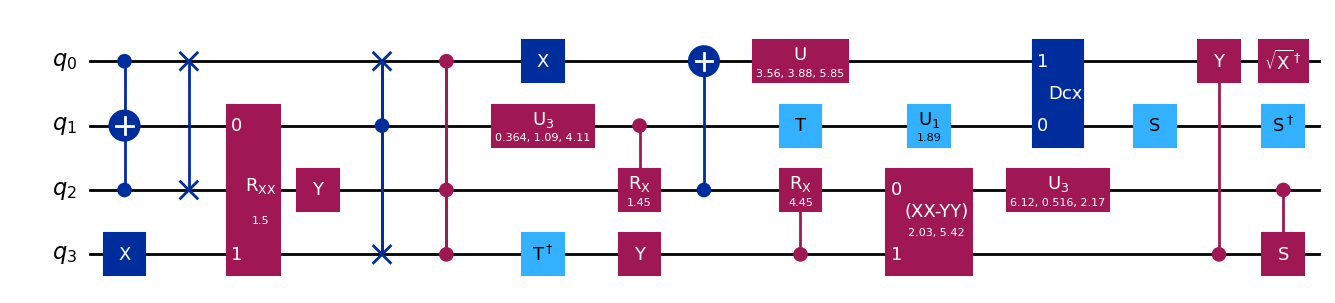

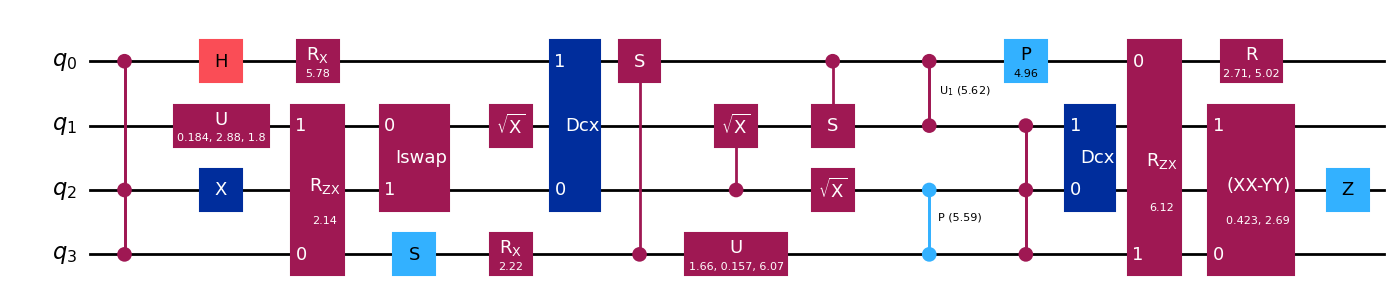

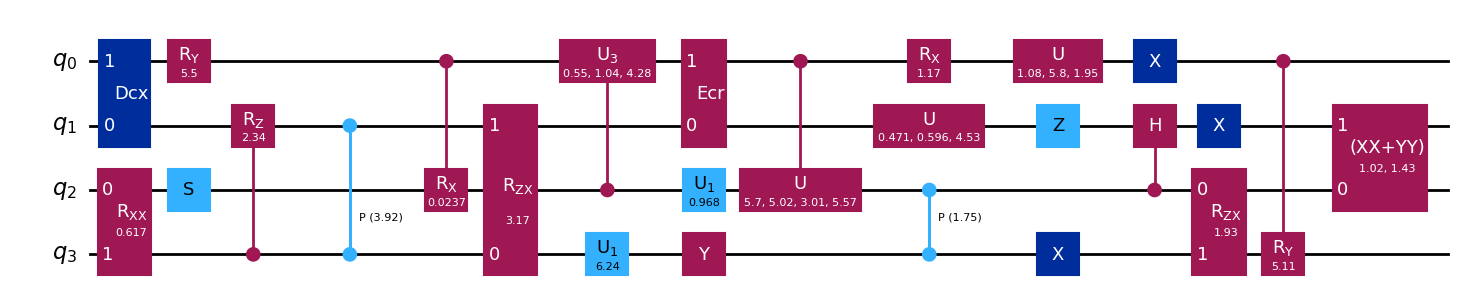

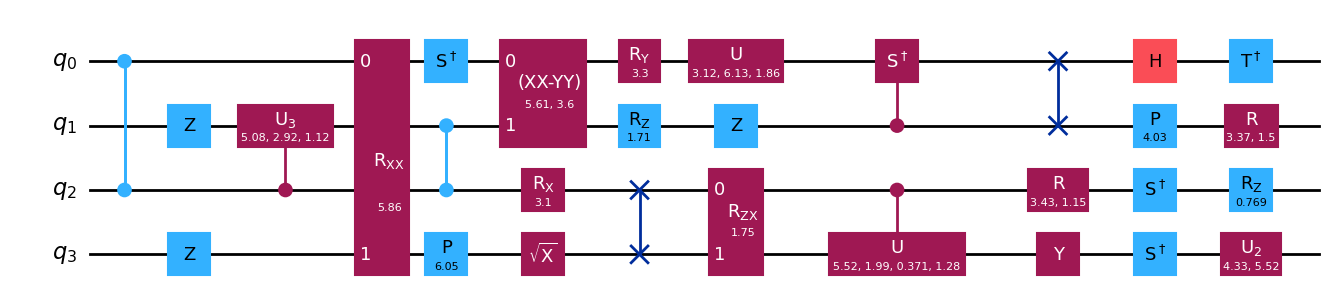

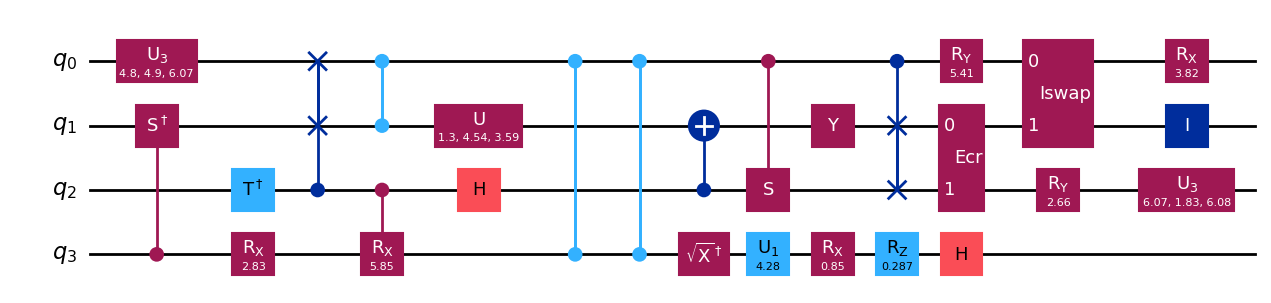

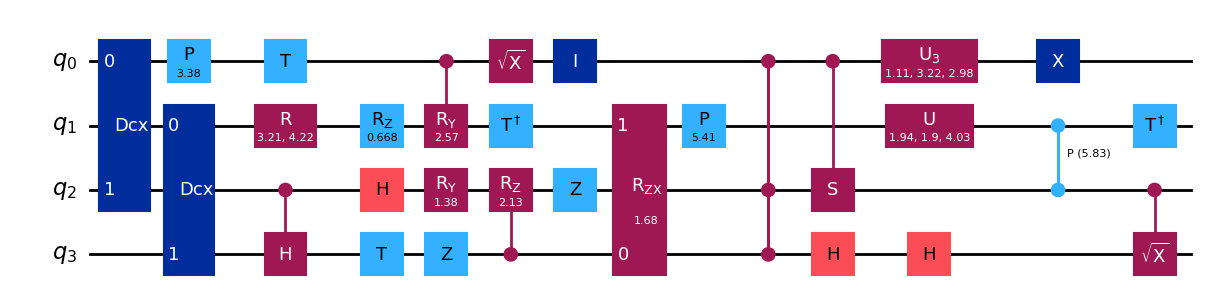

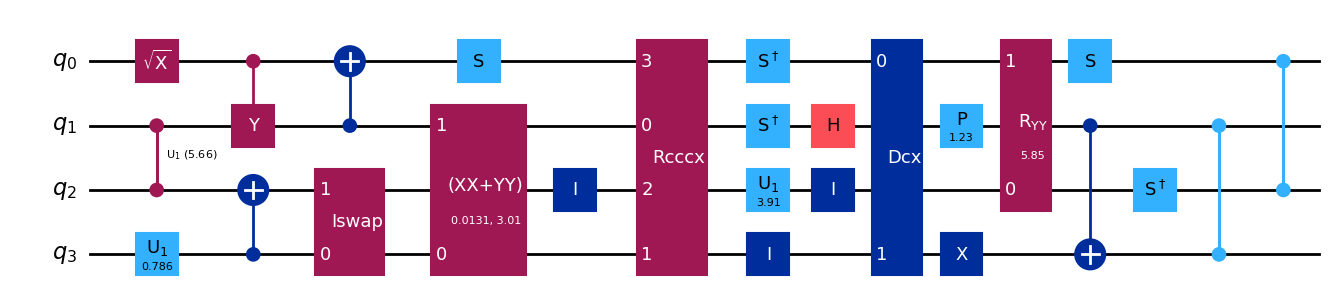

In [143]:
# generating randomized circuits
def generate_seed():

    entropy = secrets.token_bytes(16) + time.time_ns().to_bytes(8, 'big') + uuid.uuid4().bytes
    seed = int(hashlib.sha256(entropy).hexdigest(), 16) % 2**32

    return seed

seeds = []
circuits = []

for i in range(len(groups)): 
    num_wave_functions = len(groups[i][0])

    seed = generate_seed() 
    circuit = random_circuit(num_wave_functions, depth = 10, seed = seed)

    circuits.append(circuit)
    seeds.append(seed)

for i in circuits: 
    display(i.draw('mpl'))

In [144]:
# run above circuits on each group 
# uses statevector simulator backend

simulator = Aer.get_backend('statevector_simulator')
final_wave_functions = []
ancillary_wave_functions = []

def cycle(arr): 
    return [arr[-1]] + arr[:-1]

def run(current_wave_funcs, i):

    result_wave_functions = []

    num_wave_functions = len(current_wave_funcs)

    initial_wave_function = current_wave_funcs[0]

    for wf in current_wave_funcs[1:]:
        initial_wave_function = initial_wave_function.tensor(wf)

    main_circuit = circuits[i]
    initialization_circuit = QuantumCircuit(num_wave_functions)
    initialization_circuit.initialize(initial_wave_function.data, 
                                        [j for j in range(num_wave_functions)])

    full_circuit = initialization_circuit.compose(main_circuit)
    transpiled_circuit = transpile(full_circuit, simulator)
    result = simulator.run(transpiled_circuit).result()
    final_wave_function = result.get_statevector()
    result_wave_functions.append(final_wave_function)

    return result_wave_functions

final_wave_functions = []

for i in range(len(groups)): 
    wave_functions = groups[i][0]

    ancillary_wave_functions = []
    j = 0 
    while j < len(wave_functions): 
        wave_functions = cycle(wave_functions)
        output_wave_functions = run(wave_functions, i)

        ancillary_wave_functions.append(output_wave_functions)
        j += 1

    final_wave_functions.append(ancillary_wave_functions)

In [145]:
# get the density matrix for all the outputted
# n-qubit wavefunctions 
density_matrices = []

for i in final_wave_functions: 
    coupled_density_matrices = [] 
    
    for j in range(len(i)): 
        coupled_density_matrices.append(DensityMatrix(i[j][0]))

    density_matrices.append(coupled_density_matrices)

for i in density_matrices: 
    for j in i: 
        display(j.draw('latex'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [146]:
# calculating the fidelities of each quantum state 
# defined by each density matrix, with respect to 
# another randomized statevector

combined_string = ''.join(map(str, seeds))
hash_object = hashlib.sha256(combined_string.encode())
hex_dig = hash_object.hexdigest()[:5]
seed = int(hex_dig, 16)

randomized_pure_state = random_statevector(dims = 2**num_qubits, seed = seed)
randomized_density_matrix = DensityMatrix(randomized_pure_state)

print("Randomized Density Matrix")
display(randomized_density_matrix.draw('latex'))

fidelities = []

def calculate_fidelitiy(rho, sigma): 

    sqrt_rho = sqrtm(rho)
    product = np.dot(sqrt_rho, np.dot(sigma, sqrt_rho))
    sqrt_product = sqrtm(product)
    trace = np.trace(sqrt_product)
    
    return np.real(trace)**2

for coupled_states in density_matrices: 
    coupled_fidelities = []

    for matrix in coupled_states: 

        fidelity = calculate_fidelitiy(matrix, randomized_density_matrix)
        coupled_fidelities.append(fidelity)

    fidelities.append(coupled_fidelities)

print(pd.DataFrame(np.array(fidelities)))


Randomized Density Matrix


<IPython.core.display.Latex object>

          0         1         2         3
0  0.001799  0.171098  0.214248  0.122770
1  0.000092  0.093844  0.043517  0.055036
2  0.131131  0.012759  0.004038  0.063174
3  0.005338  0.006203  0.089559  0.133256
4  0.054863  0.118920  0.092418  0.006873
5  0.030933  0.092779  0.000981  0.057203
6  0.191937  0.000989  0.055289  0.156750
7  0.003056  0.007194  0.004099  0.008952


In [147]:
# convert each fidelity value in a group to a weight
# such that all weights in a group sum to 1

weights = [] 

for values in fidelities: 
    coupled_weights = []
    total = 0 
    for fidelity in values: 
        total += fidelity 

    for fidelity in values: 
        coupled_weights.append(fidelity / total)

    weights.append(coupled_weights) 

# sum of values in each row is 1
print(pd.DataFrame(np.array(weights)))

          0         1         2         3
0  0.003529  0.335542  0.420163  0.240766
1  0.000476  0.487529  0.226077  0.285918
2  0.621174  0.060441  0.019127  0.299258
3  0.022777  0.026470  0.382149  0.568604
4  0.200910  0.435485  0.338436  0.025170
5  0.170060  0.510064  0.005395  0.314481
6  0.473959  0.002442  0.136528  0.387072
7  0.131138  0.308732  0.175935  0.384196


using the new weights, sum up each weight * the density matrix 
it corresponds to in each group to create a new mixed state

$$|\psi_\text{mixed}\rangle \langle \psi_\text{mixed}| = \sum_n \text{weight}_n |\psi_n\rangle \langle \psi_n | $$

In [148]:
mixed_density_matrices = []
 
for coupled_states_idx in range(len(density_matrices)):
    mixed_density_matrix = np.zeros((2**num_qubits, 2**num_qubits), dtype=np.complex128)

    for matrix_idx in range(len(density_matrices[coupled_states_idx])):
        current_matrix = density_matrices[coupled_states_idx][matrix_idx].data

        mixed_density_matrix += weights[coupled_states_idx][matrix_idx] * current_matrix


    mixed_density_matrices.append(DensityMatrix(mixed_density_matrix))

for i in mixed_density_matrices: 
    display(i.draw('latex'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [149]:
# perform spectral/eigendecomposition on the mixed matrices
# each eigenvalue/eigenvector represents the probability/potential pure state
# post-mixed state measurement 

full_eigenvalues, full_eigenvectors = [], []

for matrix in mixed_density_matrices: 

    is_unit_trace = np.isclose(np.trace(matrix), 1.0)
    is_hermitian = np.allclose(matrix, np.matrix(matrix.data).getH())

    # implement checks to ensure the provided density matrix is valid
    if not is_unit_trace: 
        raise Exception("Tr(ρ) ≠ 1")
    if not is_hermitian: 
        raise Exception("ρ not Hermitian")

    eigenvalues, eigenvectors = np.linalg.eigh(matrix.data)
    full_eigenvalues.append([eigenvalues])
    full_eigenvectors.append([eigenvectors])

    reconstructed_matrix = sum(eigenvalues[i] * np.outer(eigenvectors[:, i], 
                                np.conj(eigenvectors[:, i])) for i in range(len(eigenvalues)))

    spectral_decomp_worked = np.allclose(matrix, reconstructed_matrix)

    if not spectral_decomp_worked: 
        raise Exception("spectral decomposition failed")

print(pd.DataFrame(full_eigenvalues))

                                                   0
0  [-9.619629891603161e-17, -3.139280409813699e-1...
1  [-5.450297107981354e-17, -3.3302301899273236e-...
2  [-1.2539332526582354e-16, -3.7839743806319663e...
3  [-9.238421640586663e-17, -4.311260155854599e-1...
4  [-7.42235642466286e-17, -4.138530760138165e-17...
5  [-7.405260202268444e-17, -4.8340377856851837e-...
6  [-9.735255099539179e-17, -6.367643379987064e-1...
7  [-1.1258469562782465e-16, -5.353218721633931e-...


calculate the von-neumann entropy for each mixed_state
using their eigenvalues

$$ S(\rho) = -\sum_n \lambda_n \log(\lambda_n) $$

In [150]:
eigenvalues, eigenvectors = full_eigenvalues, full_eigenvectors

entropies = []

def calculate_entropy(eigenvalues):  

    eigenvalues = np.array(eigenvalues)
    non_zero_eigenvalues = eigenvalues[eigenvalues > 0]

    entropy = -np.sum(non_zero_eigenvalues * np.log(non_zero_eigenvalues))

    return entropy

for eigenlist in eigenvalues: 
    entropies.append(calculate_entropy(eigenlist))

entropies

[0.9142741533155818,
 0.7521397828871963,
 0.7302966120076511,
 0.8303068547398393,
 0.9492139364488597,
 1.0222384589759888,
 0.9643347362509945,
 1.1834601027600995]

In [159]:
# organizing the ordering of the mixed states based 
# on the value of their von neumann entropy
# higher entropies have lower indices

sorted_indices = np.argsort(entropies)[::-1]
		
entropies = np.array(entropies)
eigenvalues = np.array(eigenvalues)
eigenvectors = np.array(eigenvectors)

eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[sorted_indices]

# extracting all the zero eigenvalues that represent impossible states
# to retrieve upon measurement
non_zero_eigenvalue_idxs = []
for eigenlist in eigenvalues: 
    non_zero_eigenvalue_idxs.append(np.where(eigenlist[0] > 1e-10)[0])

organized_eigenvectors = []
statevectors = []

for idx in range(len(eigenvectors)):
    allowed_idxs = non_zero_eigenvalue_idxs[idx]

    organized_eigenvectors.append(eigenvectors[idx][0][allowed_idxs])

for coupled_statevectors in organized_eigenvectors: 
    for statevector in coupled_statevectors: 
        statevectors.append(Statevector(statevector))

for i in statevectors:
    display(i.draw('latex'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [165]:
# convert all the multi-qubit statevectors irreversibly
# into single-qubit statevectors via partial tracing
# i just choose to trace out the first num_qubits - 1 qubits
# leaving out the last, perhaps there is a better way?

def n_to_single(statevector): 

    single_qubit_density_matrix = partial_trace(statevector, [i for i in range(num_qubits - 1)])
    eigenvalues, eigenvectors = np.linalg.eigh(single_qubit_density_matrix.data)

    sorted_eigenvectors = np.array(eigenvectors)[np.argsort(eigenvalues)]

    return Statevector(sorted_eigenvectors[0])

final_statevectors = []

for statevec in statevectors: 
    final_statevectors.append(n_to_single(statevec))

for i in final_statevectors: 
    check = i.is_valid()
    if not check: 
        raise Exception(f"{i} is not a valid statevector")
    else: 
        display(i.draw('latex'))
    


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>